In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from matplotlib import pyplot as plt


In [8]:

# Load data
df = pd.read_parquet('snotel_data.parquet')
df = df[df.station_triplet == '1085:WA:SNTL']
df.head()

,date,snow_depth,B01,B02,B03,B04,B05,B06,B07,B08,B09,B10,is_snow,granule_id,station_triplet
4266,2013-04-30T18:57:49.955Z,136,5573,5573,5329,5191,5414,1045,1016,-9999,123,-507,0,G2246948039-LPCLOUD,1085:WA:SNTL
4267,2013-05-16T18:58:02.239Z,87,4008,4203,4684,4732,4590,114,71,-9999,10,709,1,G2244110989-LPCLOUD,1085:WA:SNTL
4268,2013-04-14T18:57:28.350Z,151,8361,8172,7721,7543,7328,1739,1768,-9999,344,-1820,0,G2246987473-LPCLOUD,1085:WA:SNTL
4269,2013-04-14T18:57:52.232Z,151,8383,8194,7749,7569,7349,1745,1775,-9999,344,-1820,0,G2246987419-LPCLOUD,1085:WA:SNTL
4270,2013-05-25T18:51:55.218Z,87,6581,6631,6445,6385,6530,4548,3768,-9999,51,-349,0,G2243830722-LPCLOUD,1085:WA:SNTL


In [9]:

# Load input and output columns from data frame
input_columns = [f"B{i:02d}" for i in range(1, 11)] + ["is_snow"]
input_data = df[input_columns].values
output_columns = ['snow_depth']
output_data = df[output_columns].values


In [10]:
# Scale data
X_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(input_data).astype(np.float32)
Y_scaler = MinMaxScaler()
Y_scaled = Y_scaler.fit_transform(output_data).astype(np.float32)

In [11]:

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, Y_scaled, test_size=0.33, random_state=42)


In [19]:
y_test[0].shape

(1,)

# Train models

## Linear model



In [12]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_y_pred = linear_model.predict(X_test)
linear_pearsonr = pearsonr(linear_y_pred, y_test)
linear_pearsonr

PearsonRResult(statistic=array([0.55405915], dtype=float32), pvalue=array([2.61175487e-20]))

## Random Forest model

In [13]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
random_forest_y_pred = rf_model.predict(X_test)
random_forest_pearsonr = pearsonr(random_forest_y_pred, y_test[:,0])
random_forest_pearsonr

/Users/aimeebarciauskas/github/ski-project/ski-project/lib/python3.12/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


PearsonRResult(statistic=np.float64(0.8735026567970244), pvalue=np.float64(8.563885084545651e-75))

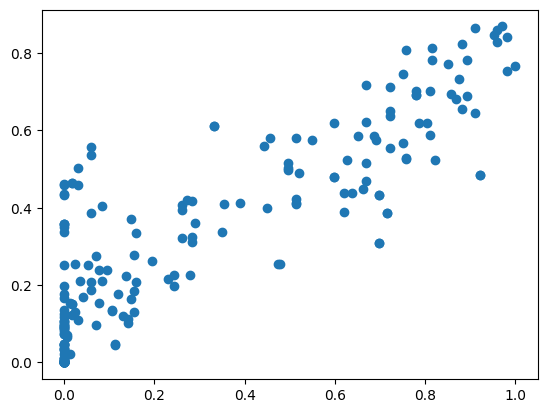

In [14]:
plt.scatter(y_test[:,0], random_forest_y_pred)

In [16]:
# Save models and scalers
import joblib

# Save individual models
joblib.dump(rf_model, 'random_forest_model.pkl')
joblib.dump(X_scaler, 'X_scaler.pkl')
joblib.dump(Y_scaler, 'Y_scaler.pkl')

print("Models and scalers saved successfully!")


Models and scalers saved successfully!
